**GAN based random text generator**

GAN is well known for it's non-discrete data generation abilities.<br>
In this notebook I'll adapt and train GAN for text generation(based on [LaText GAN](https://arxiv.org/pdf/1810.06640.pdf)). 

First, let's create data loader with tokenizer.

In [12]:
import re
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


class DataLoader:

    def __init__(self, src_csv="", src_column='', sentence_len=100, num_words=10000):
        self.__src_csv = src_csv  # source csv file with test data
        self.__src_column = src_column # column name in source file
        self.__sentence_len = sentence_len  # max sentence length
        self.__num_words = num_words  # number of most frequent words to keep
        self.__tokenizer = None # tokenizer
        self.sentences = []  # text data
        self.sequences = np.array([])  # indexed data from tokenizer

    def __load_file(self):
        df = pd.read_csv(self.__src_csv, keep_default_na=False) 
        self.sentences = [re.sub(r"<.*?>", " ", x) for x in df['review']]  # remove html tags
        self.sentences = [s.replace('.', ' .') for s in self.sentences] # let's keep period
        # rest of data cleaning is done by tokenizer

    def __init_tokenizer(self):
        # Tokenization
        # splitted by space
        # filters = default - period sign
        # unknown word set to <OOV>
        # lower case
        # saves only __num_words most frequent words
        self.tokenizer = Tokenizer(num_words=self.__num_words, lower=True, split=' ', oov_token='<OOV>', filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
        self.tokenizer.fit_on_texts(self.sentences) # fit on text data
        
    def __init_sequences(self):
        if self.sequences.size < 1:
            self.__load_file()
            self.__init_tokenizer()
            self.sequences = self.tokenizer.texts_to_sequences(self.sentences) # text to tokenizer indexes
            self.sequences = pad_sequences(self.sequences, maxlen=self.__sentence_len, dtype='float32', padding='post') # padding 
            

    def get(self):
        self.__init_sequences()
        return self.sequences

Define all parameters and paths.

In [13]:
SOURCE_FILE = "drive/MyDrive/Colab Notebooks/IMDB Dataset.csv" # test data file path (here IMDB reviews)
AE_MODEL_PATH="drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce" # autoencoder path
PLOT_PATH="drive/MyDrive/Colab Notebooks/plots/{}.png" # plots path
HISTORY_PATH="drive/MyDrive/Colab Notebooks/history/{}.csv" # learning history path
EMBEDDING_PATH="drive/MyDrive/Colab Notebooks/model.txt" # path to prepared word embedding
EMBEDDING_MATRIX_PATH="embedding_matrix.npy" # path to embedding matrix

MAX_WORD_NUM = 3250 # max number of most frequent words to save
MAX_SEQUENCE_LEN = 20 # max sentence length
ENCODED_VECTOR_LEN = 300 # enoded sentence length
EMBEDDING_SIZE = 300 # embedding vector length

Load our data.

In [14]:
dataLoader = DataLoader(SOURCE_FILE, sentence_len=MAX_SEQUENCE_LEN, num_words=MAX_WORD_NUM)
data = dataLoader.get()

np.random.seed(2137)
np.random.shuffle(data) 

data.shape

(50000, 20)

Now, we need to create embedding matrix (saved in EMBEDDING_MATRIX_PATH). To do this already trained word embedding model is necessary. Embedding matrix will keep vectors for words from vocabulary/tokenizer.



Word embedding model is meant to represent complex relationships between words (i.e. 'female', 'girl', 'woman' - similar concept, but completly different spelling) by placing each word in some N dimensional space.

Here I use 300 dimensional model only for english.


In [15]:
# read word embedding model
# each line consist of word and X normalized values
embeddings_index = {}
f = open(EMBEDDING_PATH, 'r')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
        continue
    embeddings_index[word] = coefs
f.close()

# build embedding matrix
num_words = min(MAX_WORD_NUM, len(dataLoader.tokenizer.word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, i in dataLoader.tokenizer.word_index.items():
    if i >= MAX_WORD_NUM:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector.astype('float32')   
    else:
        embedding_matrix[i] = np.random.normal(-0.25, 0.25, EMBEDDING_SIZE)

np.save(EMBEDDING_MATRIX_PATH, embedding_matrix) # save matrix
embedding_matrix.shape

(3250, 300)

In case of hardware limitations You might want to use this simple data generator.

Autoencoder(explained below) produces data in one-hot encoding, that's why we need to convert y_train.

Standard encoding:<br>
[0, 3]

one-hot:<br>
[<br>
     &ensp;  [1, 0, 0, 0],<br>
    &ensp;     [0, 0, 0, 1]<br>
]



In [16]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# if you need to convert sequence to word embedding form
embedding_matrix = np.load(EMBEDDING_MATRIX_PATH) 
def get_embedding(seq):
    return np.array([embedding_matrix[int(w)] for w in seq])

class Mygenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data = data # in/out data
        self.batch_size = batch_size
    
    def on_epoch_end(self): 
        # shuffling each epoch
        np.random.shuffle(self.data) 

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size))) # number of batches

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size] # batch
        x = batch_x
        y = np.array([to_categorical(seq, num_classes=MAX_WORD_NUM) for seq in batch_x]) # y data in one-hot
        return x, y

**AUTOENCODER**

Autoencoder is a pair of two networks - encoder and decoder - connected with 'bottleneck'. Encoder is meant to represent each sequence in compressed form(i.e. 20 seq with 300D embedding requires 6000 values, this encoder will compress it to 300), while decoder decompresses it.

This autoencoder takes whole sequence and outputs whole sequence at once!

<br>
Encoder: <br>
&ensp; input - sequences of indexes from tokenizer<br>
&ensp; output - compressed vector 

<br>
Decoder: <br>
&ensp; input - compressed vector<br>
&ensp; output - sequences of indexes in one-hot encoding



In [17]:
import keras.backend as K
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint

# ENCODER
# 1D input of indexes from tokenizer
inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')

# this layer converts indexes to embedding form using prepared embedding_matrix
e = Embedding(MAX_WORD_NUM, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LEN, trainable=False)(inputs)

# stacked LSTM layers
# depending on your parametrs you might want to stack more LSTMs
encoded = Bidirectional(LSTM(ENCODED_VECTOR_LEN, return_sequences=True, name="encoder_bi_lstm"), name="encoder_bi")(e)
# encoder output in form of compressed 1D vector
encoded = LSTM(ENCODED_VECTOR_LEN, name="encoder")(encoded)


# DECODER
# decoder input repeats compressed vector to decode whole sequence
decode_input = RepeatVector(MAX_SEQUENCE_LEN, name="decoder_input")(encoded)

# stacked LSTM layers
decode_input = LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_lstm")(decode_input)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_bi_lstm"), name="decoder_bi")(decode_input)

# one-hot encoding mapping
# TimeDistributed allows to apply Dense to each word in sequence
decoded = TimeDistributed(Dense(MAX_WORD_NUM, activation='softmax'), name="decoder")(decoded)

autoencoder = Model(inputs, decoded) 

# categorical crossentropy is great to use with one-hot encoding
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
autoencoder.summary() 

autoencoder.save(AE_MODEL_PATH) # save untrained model

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 300)           975000    
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                           

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


In [18]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger

# split data
# if you just want to create autoencoder there's no need for validation set
# here I take small batch for validation to see how well autoencoder responds to unseen data, which will be produced by GAN
split_ind = int(len(data) * 0.96) 
data_train = data[:split_ind,:]
data_val = data[split_ind:,:]
print(data_val.shape)

autoencoder = load_model(AE_MODEL_PATH) # load model
autoencoder.summary()

csv_logger = CSVLogger(HISTORY_PATH.format("AE"), append=True) # log history to file
checkpoint = ModelCheckpoint(filepath=AE_MODEL_PATH, save_best_only=True) # save best model for unseen data

# 64 might be optimal
batch_size = 32

# 90% on training set after around 10 epochs
# 50 epochs is enough for current parametrs to maximize result
# depending on vocab size, sentence length etc. I achieved
# >99% on training set, 92-95 % on unseen data from same set
history = autoencoder.fit(x=Mygenerator(data_train, batch_size), epochs=50, validation_data=Mygenerator(data_val, batch_size), callbacks=[checkpoint, csv_logger])

(2000, 20)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 300)           975000    
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 167s 104ms/step - loss: 5.3270 - accuracy: 0.1593 - val_loss: 4.8189 - val_accuracy: 0.2236
Epoch 2/50
1500/1500 [==============================] - ETA: 0s - loss: 4.1069 - accuracy: 0.3129

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 150s 100ms/step - loss: 4.1069 - accuracy: 0.3129 - val_loss: 3.4546 - val_accuracy: 0.4016
Epoch 3/50
1500/1500 [==============================] - ETA: 0s - loss: 2.8652 - accuracy: 0.4811

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 150s 100ms/step - loss: 2.8652 - accuracy: 0.4811 - val_loss: 2.5002 - val_accuracy: 0.5401
Epoch 4/50
1500/1500 [==============================] - ETA: 0s - loss: 2.1349 - accuracy: 0.5835

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 151s 100ms/step - loss: 2.1349 - accuracy: 0.5835 - val_loss: 1.9716 - val_accuracy: 0.6166
Epoch 5/50
1500/1500 [==============================] - ETA: 0s - loss: 1.6382 - accuracy: 0.6582

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 152s 101ms/step - loss: 1.6382 - accuracy: 0.6582 - val_loss: 1.5889 - val_accuracy: 0.6707
Epoch 6/50
1500/1500 [==============================] - ETA: 0s - loss: 1.2698 - accuracy: 0.7187

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 151s 101ms/step - loss: 1.2698 - accuracy: 0.7187 - val_loss: 1.3061 - val_accuracy: 0.7190
Epoch 7/50
1500/1500 [==============================] - ETA: 0s - loss: 0.9539 - accuracy: 0.7769

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 150s 100ms/step - loss: 0.9539 - accuracy: 0.7769 - val_loss: 1.0378 - val_accuracy: 0.7688
Epoch 8/50
1500/1500 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.8270

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 152s 102ms/step - loss: 0.7110 - accuracy: 0.8270 - val_loss: 0.8592 - val_accuracy: 0.8025
Epoch 9/50
1500/1500 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8679

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 151s 100ms/step - loss: 0.5287 - accuracy: 0.8679 - val_loss: 0.6899 - val_accuracy: 0.8370
Epoch 10/50
1500/1500 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8994

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 151s 101ms/step - loss: 0.3966 - accuracy: 0.8994 - val_loss: 0.5856 - val_accuracy: 0.8607
Epoch 11/50
1500/1500 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.9210

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 152s 102ms/step - loss: 0.3078 - accuracy: 0.9210 - val_loss: 0.5403 - val_accuracy: 0.8668
Epoch 12/50
1500/1500 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9382

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 150s 100ms/step - loss: 0.2403 - accuracy: 0.9382 - val_loss: 0.4877 - val_accuracy: 0.8806
Epoch 13/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9504

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 152s 101ms/step - loss: 0.1939 - accuracy: 0.9504 - val_loss: 0.4516 - val_accuracy: 0.8876
Epoch 14/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9581

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 153s 102ms/step - loss: 0.1623 - accuracy: 0.9581 - val_loss: 0.4506 - val_accuracy: 0.8897
Epoch 15/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9658

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 154s 103ms/step - loss: 0.1334 - accuracy: 0.9658 - val_loss: 0.4237 - val_accuracy: 0.8946
Epoch 16/50
1500/1500 [==============================] - 110s 74ms/step - loss: 0.1135 - accuracy: 0.9710 - val_loss: 0.4445 - val_accuracy: 0.8911
Epoch 17/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9742

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 153s 102ms/step - loss: 0.1005 - accuracy: 0.9742 - val_loss: 0.3950 - val_accuracy: 0.9038
Epoch 18/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0883 - accuracy: 0.9773 - val_loss: 0.4004 - val_accuracy: 0.9019
Epoch 19/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9790

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 153s 102ms/step - loss: 0.0802 - accuracy: 0.9790 - val_loss: 0.3919 - val_accuracy: 0.9051
Epoch 20/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0723 - accuracy: 0.9811 - val_loss: 0.4060 - val_accuracy: 0.9035
Epoch 21/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9830

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 152s 102ms/step - loss: 0.0651 - accuracy: 0.9830 - val_loss: 0.3586 - val_accuracy: 0.9135
Epoch 22/50
1500/1500 [==============================] - 110s 74ms/step - loss: 0.0614 - accuracy: 0.9837 - val_loss: 0.3828 - val_accuracy: 0.9098
Epoch 23/50
1500/1500 [==============================] - 110s 74ms/step - loss: 0.0554 - accuracy: 0.9853 - val_loss: 0.3612 - val_accuracy: 0.9157
Epoch 24/50
1500/1500 [==============================] - 110s 73ms/step - loss: 0.0544 - accuracy: 0.9852 - val_loss: 0.3697 - val_accuracy: 0.9132
Epoch 25/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9865

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 151s 101ms/step - loss: 0.0494 - accuracy: 0.9865 - val_loss: 0.3554 - val_accuracy: 0.9173
Epoch 26/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0473 - accuracy: 0.9871 - val_loss: 0.3729 - val_accuracy: 0.9151
Epoch 27/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9879

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 151s 101ms/step - loss: 0.0442 - accuracy: 0.9879 - val_loss: 0.3503 - val_accuracy: 0.9195
Epoch 28/50
1500/1500 [==============================] - 110s 73ms/step - loss: 0.0433 - accuracy: 0.9879 - val_loss: 0.3524 - val_accuracy: 0.9201
Epoch 29/50
1500/1500 [==============================] - 110s 73ms/step - loss: 0.0390 - accuracy: 0.9891 - val_loss: 0.3567 - val_accuracy: 0.9190
Epoch 30/50
1500/1500 [==============================] - 110s 74ms/step - loss: 0.0395 - accuracy: 0.9888 - val_loss: 0.3829 - val_accuracy: 0.9136
Epoch 31/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9894

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 154s 103ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.3475 - val_accuracy: 0.9243
Epoch 32/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0369 - accuracy: 0.9895 - val_loss: 0.3508 - val_accuracy: 0.9234
Epoch 33/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0353 - accuracy: 0.9898 - val_loss: 0.3612 - val_accuracy: 0.9215
Epoch 34/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0321 - accuracy: 0.9907 - val_loss: 0.3559 - val_accuracy: 0.9233
Epoch 35/50
1500/1500 [==============================] - 110s 74ms/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 0.3495 - val_accuracy: 0.9249
Epoch 36/50
1500/1500 [==============================] - 110s 73ms/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 0.3584 - val_accuracy: 0.9220
Epoch 37/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0305 - accuracy: 0.9911 - val_loss: 0.359

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_3250_cce/assets


1500/1500 [==============================] - 154s 103ms/step - loss: 0.0275 - accuracy: 0.9919 - val_loss: 0.3401 - val_accuracy: 0.9263
Epoch 40/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0281 - accuracy: 0.9918 - val_loss: 0.3504 - val_accuracy: 0.9247
Epoch 41/50
1500/1500 [==============================] - 110s 74ms/step - loss: 0.0273 - accuracy: 0.9921 - val_loss: 0.3612 - val_accuracy: 0.9249
Epoch 42/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 0.3666 - val_accuracy: 0.9230
Epoch 43/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0252 - accuracy: 0.9925 - val_loss: 0.3599 - val_accuracy: 0.9256
Epoch 44/50
1500/1500 [==============================] - 112s 75ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.3679 - val_accuracy: 0.9239
Epoch 45/50
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.366

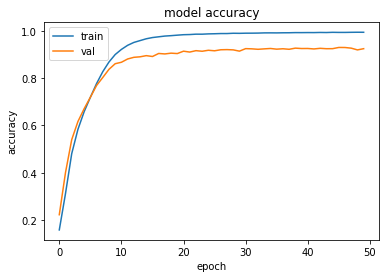

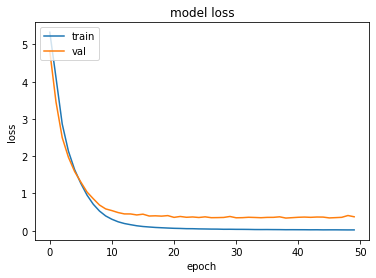

In [19]:
from matplotlib import pyplot as plt

# plot loss and accuracy and save them
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(PLOT_PATH.format('AE_accuracy'))
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(PLOT_PATH.format('AE_loss'))
plt.show()

As we can see, training data accuracy is good, but validation accuracy is relatively low.
<br><br>

Low validation accuracy (92-95%) might not be caused by LSTMs inability to encode and decode data, but by final softmax layer or significant differences in training and validation set.
<br> In GAN training we are mostly interested in generator generating values similar to training set so, if its working well, decoding accuracy of generated samples might be closer to training set accuracy (>99%)
<br>
For purposes of this excercise this is enough.

**Autoencoder test**

In [20]:
from keras import *
import keras.backend as K
from keras.layers import *
from keras.models import load_model

# load model
def load_autoencoder(path):
      model = load_model(path)

      # split into encoder and decoder
      encoder = Model(model.input, model.get_layer('encoder').output)
      decoder = Model(model.get_layer('decoder_input').input, model.get_layer('decoder').output)

      # add Argmax layer to decoder to convert results to real one-hot encoding
      one_hot_to_index = Lambda(lambda x: K.cast(K.argmax(x), dtype='float32'))(decoder.output)
      decoder = Model(decoder.input, one_hot_to_index)
      return (encoder, decoder, model)

(enc, dec, model) = load_autoencoder(AE_MODEL_PATH)

As You can see below, autoencoder works pretty well.<br>
There are some OOV tokens which implies too small vocabulary size.
<br>
Increasing vocabulary impacts learning abilities so we might need to deepen AE architecture by i.e. another Dense layer or stack more LSTMs.


In [34]:
from tensorflow.keras.utils import to_categorical

# prints input and predicted sentence
def print_test(seq):
    seq = seq.reshape(1, 20)
    predicted = model.predict(seq)
    predicted = np.argmax(predicted, axis=2) # convert one-hot to standard encoding
    
    print("IN SENTENCE         {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(seq))))
    print("PREDICTED SENTENCE  {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(predicted))))
    print("----------------------------")

print_test(data[6])
print_test(data[12])
print_test(data[19])
print_test(data[21])
print_test(data[28])
print_test(data[40071])
print_test(data[40051])
print_test(data[49998]) # validation set
print_test(data[49988])

IN SENTENCE         maybe they just weren't asked . or perhaps i suspect they actually read the script . stick to the original
PREDICTED SENTENCE  maybe they just weren't asked . or perhaps i suspect they actually read the script . stick to the original
----------------------------
IN SENTENCE         parents finally get tired of it i found 3 times in one day to be a little too much .
PREDICTED SENTENCE  parents finally get tired of it i found 3 times in one day to be a little too much .
----------------------------
IN SENTENCE         the first episode only . one only can hope the second will be better but don't bet on it .
PREDICTED SENTENCE  the first episode only . one only can hope the second will be better but don't smile on it .
----------------------------
IN SENTENCE         was a really horrible movie . i only paid one dollar to rent it but even that was too much
PREDICTED SENTENCE  was a really horrible movie . i only paid one dollar to rent it but even that was too much
---